### 导入相关库

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt 
import numpy as np 
import os
import cv2

%matplotlib inline

### 初始化训练集数据生成器

In [2]:
# specify the params
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rescale= 1/255.0,
                     rotation_range=90,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.2)
 
# 创建图像和其对应Mask的生成器
train_image_datagen = ImageDataGenerator(**data_gen_args)
train_mask_datagen = ImageDataGenerator(**data_gen_args)

# 设置相同seed，确保image与mask对应一致
seed = 1
batch_size=32

train_image_generator = train_image_datagen.flow_from_directory(
    'data/train/images',
    class_mode=None,
    batch_size=batch_size,
    target_size=(224,224),
    color_mode='rgb',
    seed=seed)
train_mask_generator = train_mask_datagen.flow_from_directory(
    'data/train/masks',
    class_mode=None,
    batch_size=batch_size,
    target_size=(224,224),
    color_mode='grayscale',
    seed=seed)

# 结合image和mask作为训练数据生成器
train_generator = zip(train_image_generator, train_mask_generator)

/opt/Anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 4002 images belonging to 1 classes.
Found 4002 images belonging to 1 classes.


### 初始化验证集的数据生成器

In [3]:
# specify the params
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rescale= 1/255.0)

 
# 创建图像和其对应Mask的生成器
val_image_datagen = ImageDataGenerator(**data_gen_args)
val_mask_datagen = ImageDataGenerator(**data_gen_args)

# 设置相同seed，确保image与mask对应一致
seed = 1
batch_size=32

val_image_generator = val_image_datagen.flow_from_directory(
    'data/val/images',
    class_mode=None,
    batch_size=batch_size,
    target_size=(224,224),
    color_mode='rgb',
    seed=seed)
val_mask_generator = val_mask_datagen.flow_from_directory(
    'data/val/masks',
    class_mode=None,
    batch_size=batch_size,
    target_size=(224,224),
    color_mode='grayscale',
    seed=seed)

# 结合image和mask作为训练数据生成器
val_generator = zip(val_image_generator, val_mask_generator)

Found 1709 images belonging to 1 classes.
Found 1709 images belonging to 1 classes.


### 定义模型网络结构

In [4]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [5]:
def unet(input_size = (224,224,3)):
    
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(1, 3, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv9)
   
    model = Model(input=inputs, output=conv9)
    
    return model

### 查看模型网络结构

In [6]:
model= unet(input_size=(224,224,3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/opt/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


### 编译模型

In [8]:
from keras.utils import multi_gpu_model
# 以数据并行的方式执行多GPU计算
parallel_model = multi_gpu_model(model, gpus=2)

# 编译并行模型
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.001, amsgrad=False)
parallel_model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=opt)

### 设置callbacks

In [ ]:
from keras.callbacksimport EarlyStopping, ModelCheckpoint

# 配置CheckPoint
check_point = ModelCheckpoint(filepath='./Models/unet.h5', monitor='val_acc', 
                             save_weights_only=False,
                             verbose=2,
                             save_best_only=True, 
                             period=1)
# 配置Early Stopping
early_stopping = EarlyStopping(monitor='val_acc', 
                               patience=10, 
                               verbose=0, 
                               mode='auto')

### 训练并保存模型到指定位置

In [9]:
# 计算相关参数：steps_per_epoch
steps_train = len(train_image_generator)
steps_val = len(val_image_generator)

# 训练模型
log =parallel_model.fit_generator(train_generator, 
                                  epochs=100, verbose=1,
                                  steps_per_epoch=steps_train,
                                  validation_data=val_generator,
                                  validation_steps=steps_val,
                                  callbacks=[early_stopping,check_point])

# 创建模型保存文件夹
folder_path = 'Models'
if not os.path.exists(folder_path):
    os.mkdir(folder_path)
    
# 保存模型到指定文件夹
file_path = os.path.join(folder_path,'unet_final.h5')
model.save(file_path)

Epoch 1/100
126/126 [==============================] - 83s 657ms/step - loss: 0.5462 - acc: 0.7275 - val_loss: 0.4475 - val_acc: 0.7547
Epoch 2/100
126/126 [==============================] - 81s 639ms/step - loss: 0.4684 - acc: 0.7498 - val_loss: 0.4570 - val_acc: 0.7719
Epoch 3/100
126/126 [==============================] - 84s 670ms/step - loss: 0.4593 - acc: 0.7582 - val_loss: 0.5440 - val_acc: 0.7497
Epoch 4/100
126/126 [==============================] - 87s 690ms/step - loss: 0.4399 - acc: 0.7700 - val_loss: 0.4019 - val_acc: 0.7880
Epoch 5/100
126/126 [==============================] - 90s 718ms/step - loss: 0.4188 - acc: 0.7814 - val_loss: 0.4290 - val_acc: 0.7719
Epoch 6/100
126/126 [==============================] - 90s 716ms/step - loss: 0.4100 - acc: 0.7870 - val_loss: 0.4080 - val_acc: 0.7913
Epoch 7/100
126/126 [==============================] - 93s 735ms/step - loss: 0.3993 - acc: 0.7923 - val_loss: 0.3650 - val_acc: 0.8090
Epoch 8/100
126/126 [===========================

Epoch 61/100
126/126 [==============================] - 97s 774ms/step - loss: 0.1993 - acc: 0.8906 - val_loss: 0.2146 - val_acc: 0.8862
Epoch 62/100
126/126 [==============================] - 94s 747ms/step - loss: 0.1983 - acc: 0.8912 - val_loss: 0.2009 - val_acc: 0.8919
Epoch 63/100
126/126 [==============================] - 96s 762ms/step - loss: 0.1996 - acc: 0.8912 - val_loss: 0.2071 - val_acc: 0.8896
Epoch 64/100
126/126 [==============================] - 94s 743ms/step - loss: 0.1995 - acc: 0.8913 - val_loss: 0.2099 - val_acc: 0.8865
Epoch 65/100
126/126 [==============================] - 94s 750ms/step - loss: 0.1934 - acc: 0.8940 - val_loss: 0.2102 - val_acc: 0.8878
Epoch 66/100
126/126 [==============================] - 93s 742ms/step - loss: 0.1889 - acc: 0.8956 - val_loss: 0.2119 - val_acc: 0.8867
Epoch 67/100
126/126 [==============================] - 95s 757ms/step - loss: 0.1935 - acc: 0.8941 - val_loss: 0.2179 - val_acc: 0.8827
Epoch 68/100
126/126 [===================

### 可视化训练指标

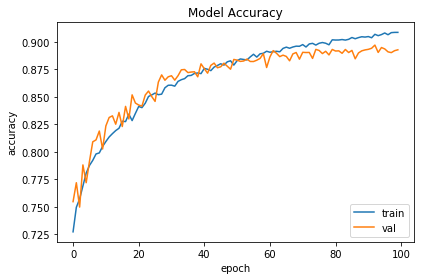

In [11]:
plt.plot(log.history['acc'])
plt.plot(log.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.tight_layout()

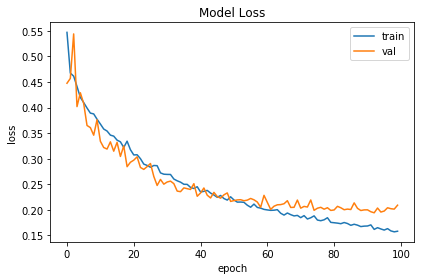

In [12]:
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.tight_layout()

### CheckPoint - 测试评估

- 导入相关库

In [12]:
from keras.models import load_model
from matplotlib import pyplot as plt
from time import time
import numpy as np
import os
import cv2

%matplotlib inline

- 导入模型

In [13]:
file_path = 'Models/unet.h5'
model = load_model(file_path) 

- 导入测试图片

In [20]:
test_images = []
for file in os.listdir('data/val/images/0'):
    file_path = os.path.join('data/val/images/0',file)
    test_images.append(file_path)

- 可视化原图和Mask

Time:1.6556s


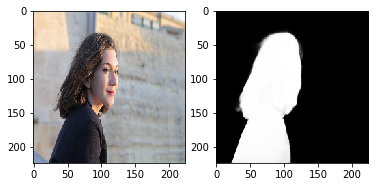

In [27]:
# 选择测试图片
img_path = test_images[0]

# 绘制原图
plt.subplot(121)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(224,224))

# 绘制Mask
plt.imshow(img.astype('uint8'))
plt.subplot(122)
img = np.reshape(img,(1,224,224,3)) / 255.0
start = time()
pred = model.predict(img)
end = time()
print('Time:%.4fs'%(end-start))
pred = np.reshape(pred,(224,224))
plt.imshow(pred, cmap='gray')